In [1]:
from pathlib import Path
import datetime
import calendar
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from matplotlib import gridspec as gridspec
from matplotlib import font_manager

from pymongo import MongoClient
from scipy.interpolate import RBFInterpolator
from packaging import version

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Inter Tight'

In [2]:
DROP_CUTOFF = "20.1"
# DROP_CUTOFF = "22.1"

# Load data
Step 0 is pulling events with the Sentry API

In [3]:
def parse(vstr):
    vstr = str(vstr)
    vstr = vstr[int(vstr.startswith("v")):]
    
    try:
        return version.parse(vstr)
    except:
        return version.parse("0.0")

vparse = np.vectorize(parse)

def load_event(event_name, unique=True):
    db = MongoClient().fmriprep_stats
    data = pd.DataFrame(list(db[event_name].find()))
    
    if len(data) == 0:
        raise RuntimeError(f"No records of event '{event_name}'")
    data.dateCreated = pd.to_datetime(data.dateCreated)
    data["date_minus_time"] = data["dateCreated"].apply(
        lambda df: datetime.datetime(year=df.year, month=df.month, day=df.day)
    )
    if unique is True:
        return data.drop_duplicates(subset=['run_uuid'])
    return data

## Load events

In [4]:
all_started = load_event("started")

In [5]:
all_success = load_event("success")

## Processing "started" event

In [6]:
unique_started = (
    all_started[vparse(all_started.environment_version.values) > version.parse(DROP_CUTOFF)] if DROP_CUTOFF
    else all_started.copy()
)

# import datetime
# DATE_CUTOFF = datetime.datetime(year=2024, month=1, day=1)
#     unique_started = unique_started[vparse(unique_started.environment_version.values) > version.parse(DROP_CUTOFF)]

In [7]:
grouped_started = unique_started.groupby([
    unique_started['date_minus_time'].dt.isocalendar().year,
    unique_started['date_minus_time'].dt.isocalendar().week,
])['id'].count()
grouped_started

year  week
2022  36       1129
      37       7038
      38       4995
      39       7921
      40       5620
              ...  
2025  20      18923
      21      20182
      22      17117
      23      16033
      24       7648
Name: id, Length: 145, dtype: int64

## Processing "success" event

In [8]:
unique_success = (
    all_success[vparse(all_success.environment_version.values) > version.parse(DROP_CUTOFF)] if DROP_CUTOFF
    else all_success.copy()
)

In [9]:
grouped_success = unique_success.groupby([
    unique_success['date_minus_time'].dt.isocalendar().year,
    unique_success['date_minus_time'].dt.isocalendar().week,
])['id'].count()
grouped_success

year  week
2022  36        621
      37       4522
      38       3652
      39       5364
      40       4085
              ...  
2025  20      12382
      21      13905
      22      11532
      23      10900
      24       4737
Name: id, Length: 145, dtype: int64

In [10]:
unique_started_success = unique_success.loc[unique_success['run_uuid'].isin(unique_started['run_uuid'])]
grouped_started_success = unique_started_success.groupby([
    unique_started_success['date_minus_time'].dt.isocalendar().year,
    unique_started_success['date_minus_time'].dt.isocalendar().week,
])['id'].count()

In [11]:
indexes = grouped_success.index[1:-1]

year_index = indexes.droplevel("week")
years = sorted(year_index.unique())
weeks_per_year = [(year_index == yr).sum() for yr in years]

## Successful runs per week

In [12]:
# Extract some summary stats
success_data = grouped_success[indexes]
started_data = grouped_started[indexes]

abs_success_mean = success_data.values.mean()

success_ratio = 100 * success_data / started_data
success_mean = success_ratio.values.mean()

max_success = (np.argmax(success_ratio), success_ratio.values.max())
max_date = indexes[max_success[0]]
min_success = (np.argmin(success_ratio), success_ratio.values.min())
min_date = indexes[min_success[0]]

<Figure size 640x480 with 0 Axes>

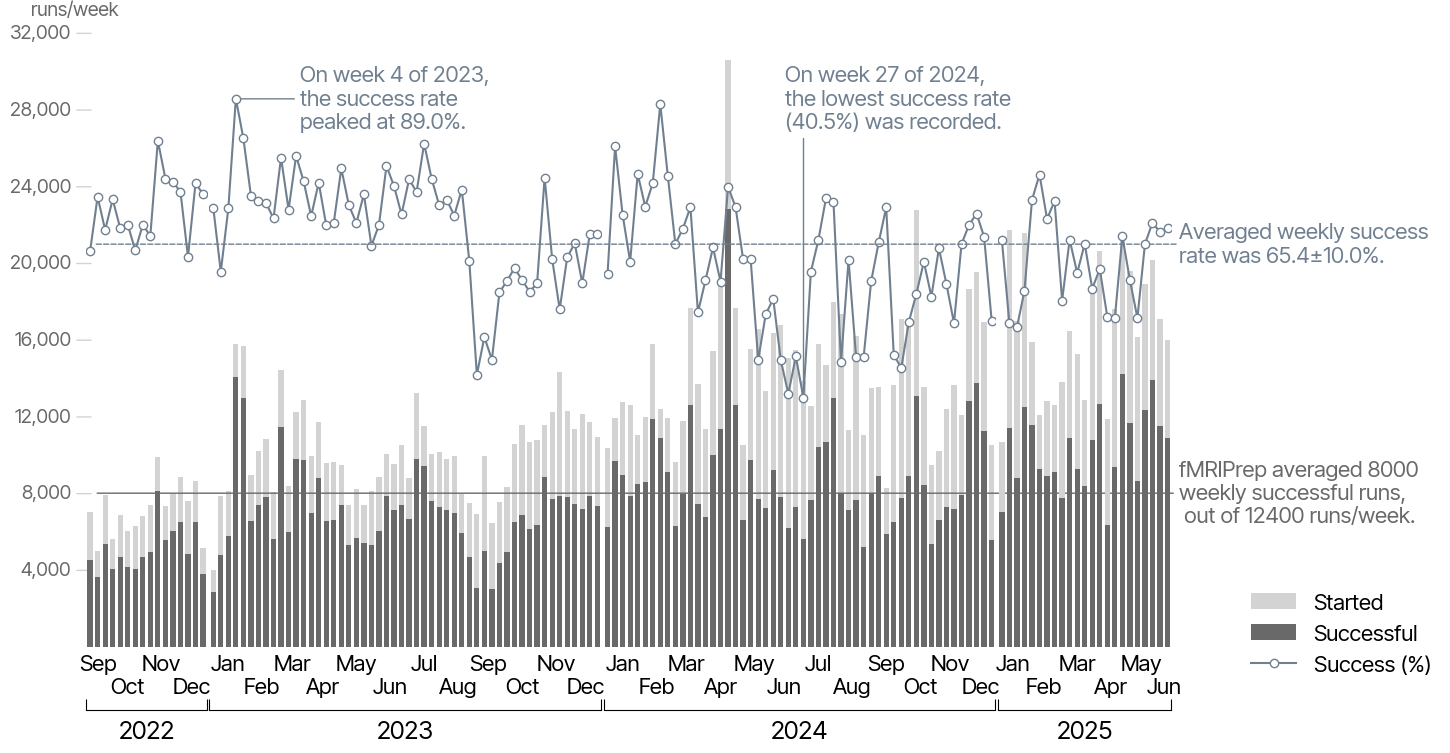

In [13]:


plt.clf()

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(years),
    sharey=True,
    gridspec_kw={
        "width_ratios": weeks_per_year,
        "wspace": 0.01,
        "hspace": 0.0,
    },
    figsize=(14,8),
)

xlength = [(year_index == yr).sum() for yr in years]
yticks = [4000, 8000, 12000, 16000]
year_start_index = 0


# Configure y-axis arts
axes[0].set_yticks(yticks, labels=yticks)
axes[0].yaxis.set_tick_params(length=25, labelsize=16)
axes[0].spines['left'].set_position(('outward', 30))
axes[0].spines['left'].set_color("dimgray")
axes[0].set_ylabel("runs/week", color="dimgrey", fontsize=14, rotation="horizontal");
axes[0].yaxis.set_label_coords(-0.1, 1.02)
axes[0].yaxis.set_label_position("left")


axes_twins = []
for ax_i, yr in enumerate(years):
    x = np.arange(len(started_data[year_index == yr]), dtype=float) + 0.5
    
    bar1 = axes[ax_i].bar(
        x,
        started_data[year_index == yr].values,
        width=0.7,
        label='Started',
        color="lightgrey",
    )
    bar2 = axes[ax_i].bar(
        x,
        success_data[year_index == yr].values,
        width=0.7,
        label='Successful',
        color="dimgrey",
    )

    axes[ax_i].spines['right'].set_visible(False)
    axes[ax_i].spines['top'].set_visible(False)
    axes[ax_i].spines['left'].set_visible(False)
    axes[ax_i].spines['bottom'].set_position(('outward', 45))
    
    axes[ax_i].set_xlim((0.0, xlength[ax_i]))
    axes[ax_i].set_xticks((0.0, xlength[ax_i]))
    axes[ax_i].set_xticklabels([])
    axes[ax_i].tick_params(direction="in", length=8)
    axes[ax_i].set_xlabel(f"{yr}", fontsize=18)

    axes[ax_i].yaxis.set_tick_params(length=0)

    if ax_i > 0:
        axes[ax_i].set_yticks([])
        
    axes_twins.append(axes[ax_i].twinx())
    ax2 = axes_twins[-1]
    lineplot = ax2.plot(
        x,
        success_ratio[year_index == yr].values,
        'o-',
        label="Success (%)",
        color="slategray",
        mfc="white",
        zorder=4,
    )
    ax2.set_ylim(0, 100)
    ax2.set_yticks([])

    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    
    # Label months
    months = [
        datetime.datetime.strptime(f'{yr}-W{week}-1', "%Y-W%W-%w").month
        for _, week in indexes[year_index == yr]
    ]
    for mnum in sorted(set(months)):
        month_x = 0.5 * (xlength[ax_i] - months[::-1].index(mnum) + months.index(mnum))
        axes[ax_i].text(
            month_x,
            -1200 - 1200 * ((mnum + 1) % 2),
            f"{calendar.month_abbr[mnum]}",
            fontsize=16,
            ha="center",
#             transform="data",
        )
        
    axes[ax_i].set_zorder(10)
    ax2.set_zorder(11)

# Add y-axis labels
for i in np.arange(4, 33, step=4, dtype=int):
    axes[0].annotate(
        f"{i},000",
        xy=(1, i * 1000),
        xytext=(-2, i * 1000),
        xycoords="data",
        annotation_clip=False,
        color="dimgrey",
        size=14,
        horizontalalignment="right",
        verticalalignment="center",
        arrowprops={"arrowstyle": "-", "color": "lightgrey"},
    ).set_zorder(0)


# Add annotations
axes[-1].annotate(
    "fMRIPrep averaged"
    f" {int(round(abs_success_mean, -2))}"
    "\nweekly successful runs,\n"
    f" out of {int(round(grouped_started.values[1:-1].mean(), -2))} runs/week.",
    xy=(0 - sum(xlength[:-1]), abs_success_mean),
    xytext=(xlength[-1] + 1, abs_success_mean),
    xycoords="data",
    annotation_clip=False,
    color="dimgrey",
    size=16,
    horizontalalignment="left",
    verticalalignment="center",
    arrowprops={"arrowstyle": "-", "color": "dimgrey"},
    zorder=0,
).set_zorder(0)

axes_twins[-1].annotate(
    "Averaged weekly success\n"
    f"rate was {round(success_mean, 1)}±{round(success_ratio.values.std(), 0)}%.",
    xy=(0 - sum(xlength[:-1]), success_mean),
    xytext=(xlength[-1] + 1, success_mean),
    xycoords="data",
    annotation_clip=False,
    color="slategray",
    size=16,
    horizontalalignment="left",
    verticalalignment="center",
    arrowprops={"arrowstyle": "-", "color": "slategray",  "linestyle" : "--", "shrinkA": 0, "shrinkB": 0},
).set_zorder(0)

y_idx = years.index(max_date[0])
axes_twins[y_idx].annotate(
    f"On week {max_date[1]} of {max_date[0]},"
    "\nthe success rate\npeaked at "
    f"{round(max_success[1], 1)}%.",
    xy=(max_date[1] - 0.5, round(max_success[1], 1)),
    # xytext=(sum(xlength[y_idx:]) + 1, round(max_success[1], 1)),
    xytext=(12, round(max_success[1], 1)),
    xycoords="data",
    annotation_clip=False,
    color="slategray",
    size=16,
    arrowprops={"arrowstyle": "-", "color": "slategray"},
    horizontalalignment="left",
    verticalalignment="center"
)

y_idx = years.index(min_date[0])
axes_twins[y_idx].annotate(
    f"On week {min_date[1]} of {min_date[0]},"
    "\nthe lowest success rate \n"
    f"({round(min_success[1], 1)}%) was recorded.",
    xy=(min_date[1] - 0.5, round(min_success[1], 1)),
    # xytext=(sum(xlength[y_idx:]) + 1, 26),
    xytext=(xlength[-1] + 1, round(max_success[1], 1)),
    xycoords="data",
    annotation_clip=False,
    color="slategray",
    size=16,
    arrowprops={"arrowstyle": "-", "color": "slategray", "connectionstyle": "angle,angleA=0,angleB=90"},
    horizontalalignment="left",
    verticalalignment="center"
)

patches = [bar1, bar2, lineplot[0]]
fig.legend(
    patches,
    [p.get_label() for p in patches],
    loc='lower right',
    bbox_to_anchor=(1.1, 0.05),
    frameon=False,
    mode=None,
    prop={"size": 16}
);

plt.savefig(
    f"{datetime.date.today().strftime('%Y%m%d')}_weekly.png",
    dpi=300,
    bbox_inches='tight',
    facecolor="w",
    edgecolor="w",
);

## Massage versions

In [14]:
unique_started = unique_started.fillna(value={"environment_version": "older"})
unique_started_success = unique_started_success.fillna(value={"environment_version": "older"})

unique_started.loc[unique_started.environment_version == "v0.0.1", "environment_version"] = "older"
unique_started_success.loc[unique_started_success.environment_version == "v0.0.1", "environment_version"] = "older"

unique_started.loc[unique_started.environment_version.str.startswith("20.0"), "environment_version"] = "older"
unique_started_success.loc[unique_started_success.environment_version.str.startswith("20.0"), "environment_version"] = "older"

unique_started.loc[unique_started.environment_version.str.startswith("20.1"), "environment_version"] = "older"
unique_started_success.loc[unique_started_success.environment_version.str.startswith("20.1"), "environment_version"] = "older"

versions = sorted(set([
    ".".join(v.split(".")[:2])
    for v in set(unique_started.environment_version.values)
    if "." in v
]))

for v in versions:
    unique_started.loc[unique_started.environment_version.str.startswith(v), "environment_version"] = v
    unique_started_success.loc[unique_started_success.environment_version.str.startswith(v), "environment_version"] = v

Check versions have been properly renamed:

In [15]:
print(sorted(unique_started.environment_version.unique()))
print(sorted(unique_started_success.environment_version.unique()))

['20.2', '21.0', '22.0', '22.1', '23.0', '23.1', '23.2', '24.0', '24.1', '25.0', '25.1', 'older']
['20.2', '21.0', '22.0', '22.1', '23.0', '23.1', '23.2', '24.0', '24.1', '25.0', '25.1', 'older']


# Analysis by version

In [16]:
versions_success = {}
versions_started = {}

for version in versions:
    ver_suc = unique_started_success[unique_started_success.environment_version == version]
    ver_sta = unique_started[unique_started.environment_version == version]
    
    versions_success[version] = ver_suc.groupby([
        ver_suc['date_minus_time'].dt.isocalendar().year,
        ver_suc['date_minus_time'].dt.isocalendar().week,
    ])['id'].count()
    versions_started[version] = ver_sta.groupby([
        ver_sta['date_minus_time'].dt.isocalendar().year,
        ver_sta['date_minus_time'].dt.isocalendar().week,
    ])['id'].count()

versions_success = pd.DataFrame(versions_success)
versions_started = pd.DataFrame(versions_started)
versions_success_norm = versions_success.div(versions_success.sum(axis=1), axis=0)
versions_success.sum(0).astype(int)

20.2    145860
21.0    113265
22.0     73220
22.1     72270
23.0     84130
23.1    223527
23.2    183381
24.0     55944
24.1    137785
25.0     37147
25.1      3487
dtype: int64

In [17]:
# Ignore columns of versions below 5000 executions all time
versions_success = versions_success.loc[:, versions_success.sum(0) > 5000]

data = versions_success[1:-1].fillna(0.0)
xs = np.arange(len(data))
xnew = np.linspace(0.0, len(data), num=14 * len(data))
xnew_inc = xnew[1] - xnew[0]

smoothed_data = RBFInterpolator(xs[:, np.newaxis], data.values)(xnew[:, np.newaxis])

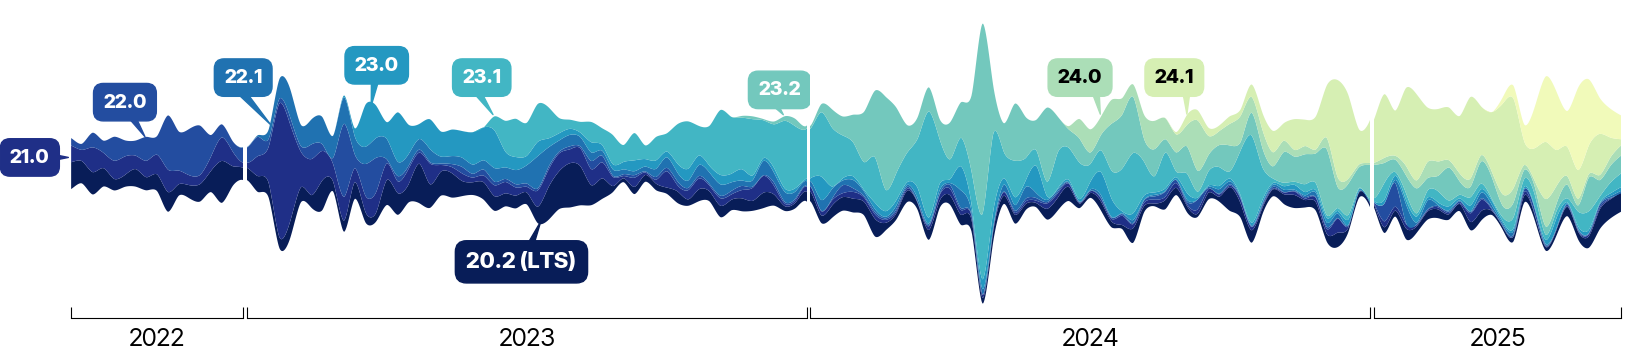

In [18]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=len(years),
    sharey="row",
    gridspec_kw={
        "width_ratios": weeks_per_year,
        "wspace": 0.01,
        "hspace": 0.0,
    },
    figsize=(20,4),
)

labels = versions_success.columns
colors = [plt.cm.YlGnBu_r(i / (len(labels))) for i, _ in enumerate(labels)]

xlims = []
year_start_index = 0
for ax_i, yr in enumerate(years):
    if ax_i > 0:
        axes[ax_i].set_yticklabels([])
        axes[ax_i].set_yticks([])

    xaxis = np.arange(len(data[year_index == yr]))
    axes[ax_i].stackplot(
        xnew,
        smoothed_data.T,
        baseline="sym",
        labels=labels,
        colors=colors,
    )
     
    axes[ax_i].spines['right'].set_visible(False)
    axes[ax_i].spines['top'].set_visible(False)
    axes[ax_i].spines['left'].set_visible(False)
    # axes[ax_i].spines['bottom'].set_visible(False)
    
    year_end_index = year_start_index + weeks_per_year[ax_i]
    xlims.append((year_start_index, year_end_index))
    
    axes[ax_i].set_xlim(xlims[-1])
    axes[ax_i].set_xticklabels([])
    axes[ax_i].set_xticks(xlims[-1])
    axes[ax_i].tick_params(direction="in", length=8)
    axes[ax_i].set_xlabel(f"{yr}", fontsize=18)
    year_start_index = year_end_index


axes[0].annotate(
    labels[1],  # 21.0
    xy=(0, 500),
    xytext=(-2, 500),
    textcoords='data',
    xycoords="data",
    fontweight=800,
    annotation_clip=False,
    color="w",
    size=14,
    horizontalalignment="right",
    verticalalignment="center",
    bbox={
        "boxstyle": "round",
        "fc": colors[1],
        "ec": colors[1],
        "color": "w",
        "pad": 0.5,
    },
    arrowprops={
        "arrowstyle": "wedge,tail_width=.5",
        "color": colors[1],
        "patchA": None,
        "patchB": None,
        "relpos": (0.8, 0.5),
    },
)

axes[0].annotate(
    labels[2],  # 22.0
    xy=(7, 2000),
    xytext=(5, 5000),
    textcoords='data',
    xycoords="data",
    fontweight=800,
    annotation_clip=False,
    color="w",
    size=14,
    horizontalalignment="center",
    verticalalignment="center",
    bbox={
        "boxstyle": "round",
        "fc": colors[2],
        "ec": colors[2],
        "color": "w",
        "pad": 0.5,
    },
    arrowprops={
        "arrowstyle": "wedge,tail_width=.5",
        "color": colors[2],
        "patchA": None,
        "patchB": None,
        "relpos": (0.5, 0.3),
    },
)


axes[2].annotate(
    labels[3],  # 22.1
    xy=(xlims[1][0] + 2, 3000),
    xytext=(xlims[1][0] - 2.5, 7000),
    textcoords='data',
    xycoords="data",
    fontweight=800,
    annotation_clip=False,
    color="w",
    size=14,
    horizontalalignment="left",
    verticalalignment="center",
    bbox={
        "boxstyle": "round",
        "fc": colors[3],
        "ec": colors[3],
        "color": "w",
        "pad": 0.5,
    },
    arrowprops={
        "arrowstyle": "wedge,tail_width=.5",
        "color": colors[3],
        "patchA": None,
        "patchB": None,
        "relpos": (0.2, 0.3),
    },
)

axes[1].annotate(
    labels[4],  # 23.0
    xy=(xlims[1][0] + 11.5, 4500),
    xytext=(xlims[1][0] + 10, 8000),
    textcoords='data',
    xycoords="data",
    fontweight=800,
    annotation_clip=False,
    color="w",
    size=14,
    horizontalalignment="left",
    verticalalignment="center",
    bbox={
        "boxstyle": "round",
        "fc": colors[4],
        "ec": colors[4],
        "color": "w",
        "pad": 0.5,
    },
    arrowprops={
        "arrowstyle": "wedge,tail_width=.5",
        "color": colors[4],
        "patchA": None,
        "patchB": None,
        "relpos": (0.5, 0.3),
    },
)

axes[1].annotate(
    labels[5],  # 23.1
    xy=(xlims[1][0] + 23, 3800),
    xytext=(xlims[1][0] + 20, 7000),
    textcoords='data',
    xycoords="data",
    fontweight=800,
    annotation_clip=False,
    color="w",
    size=14,
    horizontalalignment="left",
    verticalalignment="center",
    bbox={
        "boxstyle": "round",
        "fc": colors[5],
        "ec": colors[5],
        "color": "w",
        "pad": 0.5,
    },
    arrowprops={
        "arrowstyle": "wedge,tail_width=.5",
        "color": colors[5],
        "patchA": None,
        "patchB": None,
        "relpos": (0.2, 0.3),
    },
)

axes[1].annotate(
    "20.2 (LTS)",
    xy=(xlims[1][0] + 27.4, -4500),
    xytext=(0.5 * (xlims[1][1] + 1) + 7, -8000),
    textcoords='data',
    xycoords="data",
    fontweight=800,
    annotation_clip=False,
    color="w",
    size=16,
    horizontalalignment="center",
    verticalalignment="center",
    bbox={
        "boxstyle": "round",
        "fc": colors[0],
        "ec": colors[0],
        "color": "w",
        "pad": 0.5,
    },
    arrowprops={
        "arrowstyle": "wedge,tail_width=.5",
        "color": colors[0],
        "patchA": None,
        "patchB": None,
        "relpos": (0.5, 0.3),
    },
)

axes[1].annotate(
    labels[6],  # 23.2
    xy=(xlims[1][1] - 2, 3800),
    xytext=(xlims[1][1] - 4.5, 6000),
    textcoords='data',
    xycoords="data",
    fontweight=800,
    annotation_clip=False,
    color="w",
    size=14,
    horizontalalignment="left",
    verticalalignment="center",
    bbox={
        "boxstyle": "round",
        "fc": colors[6],
        "ec": colors[6],
        "color": "w",
        "pad": 0.5,
    },
    arrowprops={
        "arrowstyle": "wedge,tail_width=.5",
        "color": colors[6],
        "patchA": None,
        "patchB": None,
        "relpos": (0.2, 0.3),
    },
)

axes[2].annotate(
    labels[7],  # 24.0
    xy=(xlims[2][0] + 27, 3800),
    xytext=(xlims[2][0] + 23, 7000),
    textcoords='data',
    xycoords="data",
    fontweight=800,
    annotation_clip=False,
    color="k",
    size=14,
    horizontalalignment="left",
    verticalalignment="center",
    bbox={
        "boxstyle": "round",
        "fc": colors[7],
        "ec": colors[7],
        "color": "w",
        "pad": 0.5,
    },
    arrowprops={
        "arrowstyle": "wedge,tail_width=.5",
        "color": colors[7],
        "patchA": None,
        "patchB": None,
        "relpos": (0.8, 0.3),
    },
)

axes[2].annotate(
    labels[8],  # 24.0
    xy=(xlims[2][1] - 17, 3800),
    xytext=(xlims[2][1] - 20, 7000),
    textcoords='data',
    xycoords="data",
    fontweight=800,
    annotation_clip=False,
    color="k",
    size=14,
    horizontalalignment="left",
    verticalalignment="center",
    bbox={
        "boxstyle": "round",
        "fc": colors[8],
        "ec": colors[8],
        "color": "w",
        "pad": 0.5,
    },
    arrowprops={
        "arrowstyle": "wedge,tail_width=.5",
        "color": colors[8],
        "patchA": None,
        "patchB": None,
        "relpos": (0.8, 0.3),
    },
)



plt.savefig(
    f"{datetime.date.today().strftime('%Y%m%d')}_versionstream.png",
    dpi=300,
    bbox_inches='tight',
)


In [33]:
def load_event(event_name, unique=True):
    db = MongoClient().fmriprep_stats
    return list(db[event_name].find())

all_failed = load_event("failed")

In [62]:
from collections import Counter

c_success = Counter([i['geo']['region'] for i in all_success['user'] if i and 'geo' in i])

In [63]:
c_started = Counter([i['geo']['region'] for i in all_started['user'] if i and 'geo' in i])

In [69]:
{k: f"{100 * c_success[k] / c_started[k]:.2f}% ({c_success[k]} / {c_started[k]})" for k in c_success}

{'China': '54.38% (10172 / 18706)',
 'United States': '65.17% (85054 / 130511)',
 'Chile': '49.91% (271 / 543)',
 'South Korea': '77.16% (2533 / 3283)',
 'Australia': '62.93% (1811 / 2878)',
 'Germany': '74.13% (5068 / 6837)',
 'Singapore': '67.44% (2270 / 3366)',
 'India': '65.77% (146 / 222)',
 'Poland': '76.24% (385 / 505)',
 'Japan': '76.42% (7699 / 10074)',
 'Hong Kong': '9.74% (1245 / 12779)',
 'Switzerland': '69.27% (381 / 550)',
 'Canada': '64.78% (3597 / 5553)',
 'United Kingdom': '53.98% (1968 / 3646)',
 'Taiwan': '69.56% (521 / 749)',
 'Finland': '73.10% (625 / 855)',
 'Romania': '86.38% (222 / 257)',
 'France': '67.28% (954 / 1418)',
 'Italy': '76.19% (2410 / 3163)',
 'Portugal': '82.63% (747 / 904)',
 'The Netherlands': '70.02% (2357 / 3366)',
 'Austria': '75.90% (466 / 614)',
 'Belgium': '49.11% (415 / 845)',
 'Israel': '68.20% (178 / 261)',
 'Spain': '70.73% (3050 / 4312)',
 'Türkiye': '64.41% (181 / 281)',
 'Argentina': '59.38% (19 / 32)',
 'United Arab Emirates': '82.8

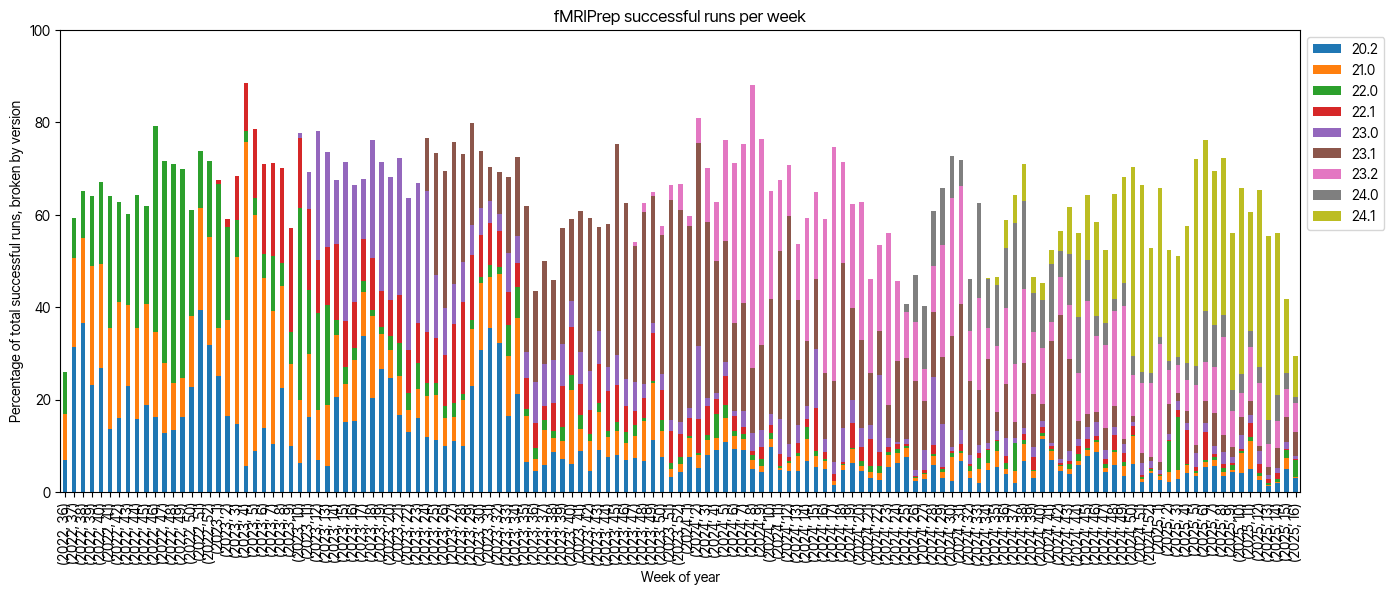

In [19]:
fig,ax = plt.subplots(figsize=(16,6))
ax = ((versions_success.T / versions_started.sum(axis=1)).T * 100).plot.bar(stacked=True, ax=ax)

ax.set_ylim((0,100))
plt.ylabel("Percentage of total successful runs, broken by version")
plt.xlabel("Week of year")
plt.title("fMRIPrep successful runs per week")
plt.legend(bbox_to_anchor=(1, 1));
plt.savefig('20221206_version_successful_weekly_rel_total.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_2310524/140250252.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1, 1));


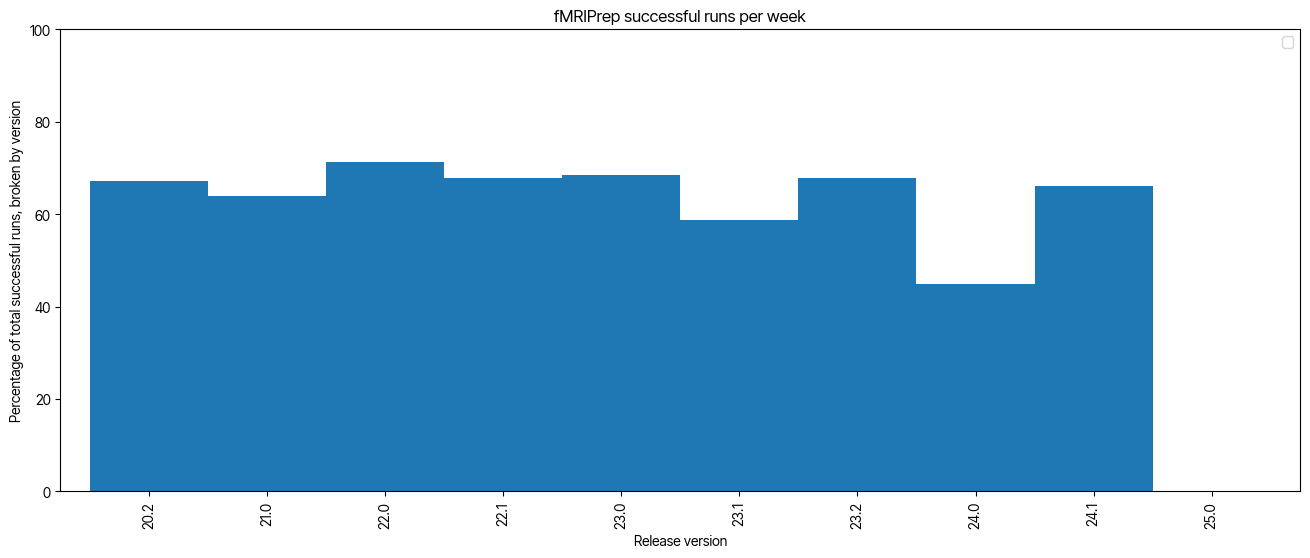

In [20]:
fig,ax = plt.subplots(figsize=(16,6))
ax = ((versions_success.sum(axis=0) / versions_started.sum(axis=0)) * 100).plot.bar(ax=ax, width=1.0)

ax.set_ylim((0,100))

plt.ylabel("Percentage of total successful runs, broken by version")
plt.xlabel("Release version")
plt.title("fMRIPrep successful runs per week")
plt.legend(bbox_to_anchor=(1, 1));
plt.savefig('20221206_version_successful_weekly_rel_broken.png', dpi=300, bbox_inches='tight')